In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import concurrent.futures
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import DBSCAN
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns


In [4]:
# Load the dataset files
ratings = pd.read_csv('ratings.csv')
to_read = pd.read_csv('to_read.csv')
books = pd.read_csv('books.csv')
book_tags = pd.read_csv('book_tags.csv')
tags = pd.read_csv('tags.csv')

In [29]:
# Initial data exploration
def explore_data(df):
    print(df.head())

In [7]:
# Explore each dataset
explore_data(ratings)
explore_data(to_read)
explore_data(books)
explore_data(book_tags)
explore_data(tags)

   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3
   user_id  book_id
0        9        8
1       15      398
2       15      275
3       37     7173
4       34      380
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.7

In [3]:
# Data Preprocessing

# Remove duplicates
ratings.drop_duplicates(inplace=True)
to_read.drop_duplicates(inplace=True)
books.drop_duplicates(subset='book_id', inplace=True)
book_tags.drop_duplicates(inplace=True)
tags.drop_duplicates(inplace=True)

# # Handle missing values
# # For simplicity, we'll drop rows with missing values. Depending on the data, more sophisticated imputation methods can be used.
# ratings.dropna(inplace=True)
# to_read.dropna(inplace=True)
# books.dropna(inplace=True)
# book_tags.dropna(inplace=True)
# tags.dropna(inplace=True)

In [22]:
a = books["authors"].value_counts().reset_index().head(10)
a.columns = ["authors", "count"]
a.head()

,authors,count
0,Stephen King,60
1,Nora Roberts,59
2,Dean Koontz,47
3,Terry Pratchett,42
4,Agatha Christie,39


C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


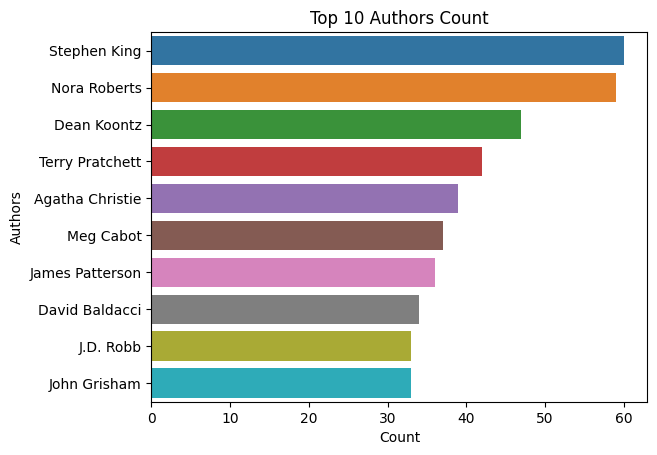

In [26]:
sns.barplot(x="count",y= "authors", data=a, palette = "tab10")
plt.xlabel("Count",fontsize=10,color="black")
plt.ylabel("Authors",fontsize=10,color="black")
plt.title("Top 10 Authors Count",color="black")
plt.show()

In [26]:
# Explore each dataset after preprocessing
explore_data(ratings)
explore_data(to_read)
explore_data(books)
explore_data(book_tags)
explore_data(tags)

   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None
   user_id  book_id
0        9        8
1       15      398
2       15      275
3       37     7173
4       34      380
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  912705 non-null  int64
 1   book_id  912705 non-null  int64
dtypes: int64(2)
memory usage: 13.9 MB
None
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023

In [5]:
top_books = ratings.groupby('book_id').size().sort_values(ascending=False).head(10).index.tolist()
top_books

[1, 2, 4, 3, 5, 17, 20, 18, 23, 7]

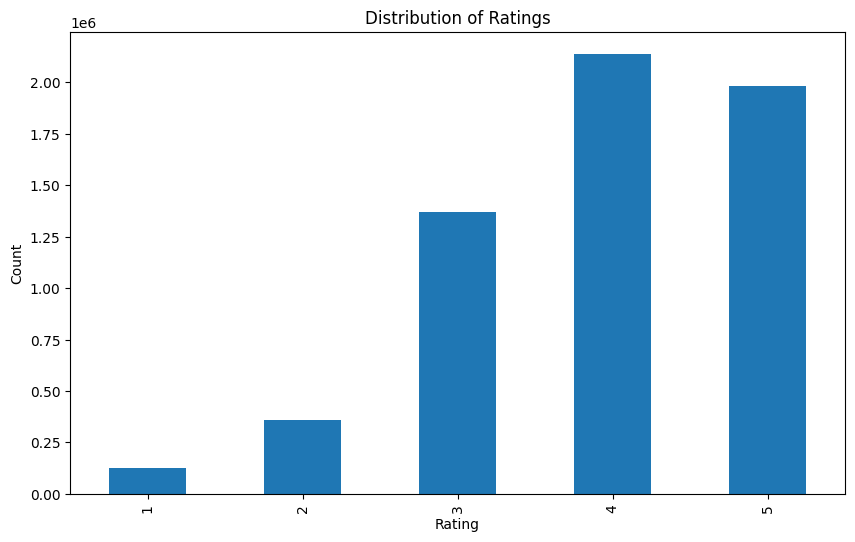

In [5]:
# Analyze distribution of ratings
plt.figure(figsize=(10, 6))
ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()



In [7]:
# Determine most popular books
popular_books = ratings.groupby('book_id')['rating'].count().sort_values(ascending=False).head(10)
print('Most Popular Books:')
print(books[books['book_id'].isin(popular_books.index)][['title', 'authors']])



Most Popular Books:
                                                title  \
0             The Hunger Games (The Hunger Games, #1)   
1   Harry Potter and the Sorcerer's Stone (Harry P...   
2                             Twilight (Twilight, #1)   
3                               To Kill a Mockingbird   
4                                    The Great Gatsby   
6                                          The Hobbit   
16               Catching Fire (The Hunger Games, #2)   
17  Harry Potter and the Prisoner of Azkaban (Harr...   
19                  Mockingjay (The Hunger Games, #3)   
22  Harry Potter and the Chamber of Secrets (Harry...   

                                    authors  
0                           Suzanne Collins  
1               J.K. Rowling, Mary GrandPré  
2                           Stephenie Meyer  
3                                Harper Lee  
4                       F. Scott Fitzgerald  
6                            J.R.R. Tolkien  
16                          Su

In [8]:
# Determine most popular authors
popular_authors = books[books['book_id'].isin(popular_books.index)]['authors'].value_counts().head(10)
print('\nMost Popular Authors:')
print(popular_authors)




Most Popular Authors:
authors
Suzanne Collins                            3
J.K. Rowling, Mary GrandPré                2
Stephenie Meyer                            1
Harper Lee                                 1
F. Scott Fitzgerald                        1
J.R.R. Tolkien                             1
J.K. Rowling, Mary GrandPré, Rufus Beck    1
Name: count, dtype: int64


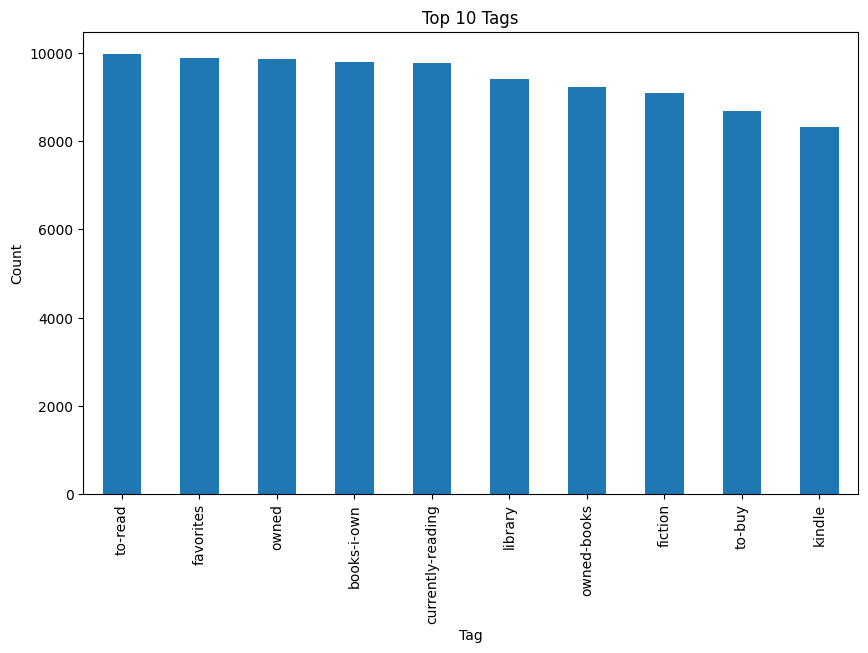

In [9]:
# Investigate distribution of tags
merged_tags = pd.merge(book_tags, tags, on='tag_id')
tag_counts = merged_tags['tag_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
tag_counts.plot(kind='bar')
plt.title('Top 10 Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

In [ ]:
len(ratings['user_id'].unique())

# 1. K-means + Q-learing

## K-means

In [43]:
# User Clustering
user_ratings = ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

### Elbow method

In [ ]:
# Sample a subset of the data for clustering
sample_size = 0.1  # Adjust this value based on your needs
sample_data = user_ratings.sample(frac=sample_size, random_state=42)
sample_data

In [25]:
# Elbow method on sampled data
inertia = []
K = range(1, 30)  # You can adjust the range based on your needs

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(sample_data)
    inertia.append(kmeans.inertia_)

C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The 

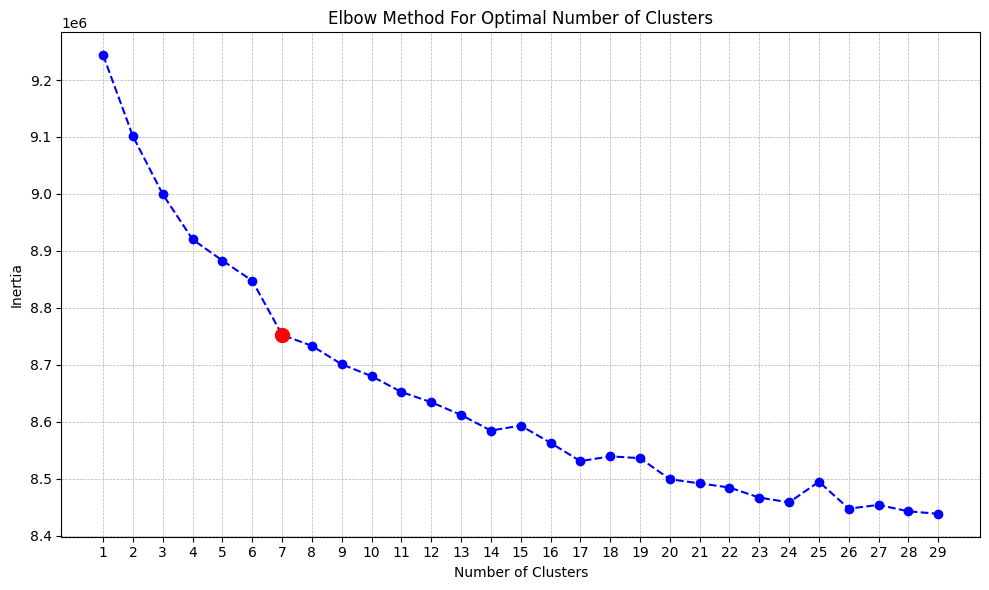

In [41]:
# Кількість кластерів
clusters = list(range(1, 30))

# Побудова графіку
plt.figure(figsize=(10,6))
plt.plot(clusters, inertia, marker='o', linestyle='--', color='b')
plt.scatter(7, inertia[6], color='red', s=100, zorder=5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(clusters)  # Set x-axis ticks to be integers for better clarity
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

### Final clustering

In [42]:
n_clusters = 7

In [22]:
clusters = pd.read_csv('clusters.csv')['cluster']

In [45]:
clusters = KMeans(n_clusters=n_clusters).fit_predict(user_ratings)

C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
pd.DataFrame(clusters, columns=['cluster']).to_csv('k-means-clusters.csv')

## Fill clusters

In [23]:
user_cluster_mapping = pd.DataFrame({'user_id': user_ratings.index, 'cluster': clusters})

# Merge this mapping with the ratings dataframe
ratings = pd.merge(ratings, user_cluster_mapping, on='user_id', how='left')

NameError: name 'user_ratings' is not defined

##### SAVE CLUSTERS

0        0
1        5
2        3
3        2
4        3
        ..
53419    0
53420    2
53421    5
53422    5
53423    5
Name: cluster, Length: 53424, dtype: int64

In [44]:
user_cluster_mapping.to_csv('clusters')

## Q-learning

### Init

In [9]:
# Q-learning initialization
n_books = len(books)
Q_tables = [np.zeros((n_books, n_books)) for _ in range(n_clusters)]
learning_rate = 0.1
discount_factor = 0.9

In [18]:
sample_size = 0.02
# Split data into training and test sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
sample_train_ratings = train_ratings.sample(frac=sample_size, random_state=42)

#### Helper functions

In [73]:
# Створимо словник to_read_dict
to_read_dict = to_read.groupby('user_id')['book_id'].apply(list).to_dict()


# Q-learning function
def q_learning(user, book, reward, next_book, alpha=0.1, gamma=0.8):
    cluster = sample_train_ratings[sample_train_ratings['user_id'] == user]['cluster'].iloc[0]
    Q = Q_tables[cluster]
    current_value = Q[book, next_book]
    Q[book, next_book] = current_value + alpha * (reward + gamma * np.max(Q[next_book, :]) - current_value)


# Recommend a book for a user
def recommend_book(user):
    if user not in sample_train_ratings['user_id'].values:
        return top_books 
    cluster = sample_train_ratings[sample_train_ratings['user_id'] == user]['cluster'].iloc[0]
    user_books = sample_train_ratings[sample_train_ratings['user_id'] == user]['book_id'].tolist()
    max_values = np.max(Q_tables[cluster][user_books, :], axis=0)
    recommended_books = np.argsort(max_values)[-10:]  # Recommend top 10 books
    return recommended_books

# Функція рекомендації книги з урахуванням списку to_read
def recommend_book_with_to_read(user):
    if user not in sample_train_ratings['user_id'].values:
        return top_books 
    cluster = sample_train_ratings[sample_train_ratings['user_id'] == user]['cluster'].iloc[0]
    user_books = sample_train_ratings[sample_train_ratings['user_id'] == user]['book_id'].tolist()
    max_values = np.max(Q_tables[cluster][user_books, :], axis=0)
    
    # Якщо користувач має список to_read, підвищимо рейтинг відповідних книг
    if user in to_read_dict:
        for book_id in to_read_dict[user]:
            if book_id < len(max_values):  # перевірка, щоб уникнути вихід за межі масиву
                max_values[book_id] += 1  # підвищимо рейтинг на 1 (або інше значення за бажанням)
    
    recommended_books = np.argsort(max_values)[-10:]  # Рекомендуємо топ-10 книг
    return recommended_books


### Training

In [20]:
# Train the Q-learning model on the sample training data
for _, row in sample_train_ratings.iterrows():
    user, book, rating = int(row['user_id']), int(row['book_id']), int(row['rating'])
    reward = 1 if rating >= 4 else -1  # Assuming a rating of 4 or 5 is positive, else negative
    next_books = recommend_book(user)
    for next_book in next_books:
        q_learning(user, book, reward, next_book)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000


In [29]:
# Apply the model to the entire dataset
all_users = ratings['user_id'].unique()
recommendations = {}

for user in all_users:
    recommended_book_ids = recommend_book(user)
    recommendations[user] = recommended_book_ids

    

#### With Wish-list

In [74]:
# Застосуємо нову функцію рекомендацій для всіх користувачів
recommendations_with_to_read = {}
for user in all_users:
    recommended_book_ids = recommend_book_with_to_read(user)
    recommendations_with_to_read[user] = recommended_book_ids

In [76]:
test_users = test_ratings['user_id'].unique()
hr_values = []
ndcg_values = []

for user in test_users:
    true_books = test_ratings[test_ratings['user_id'] == user]['book_id'].tolist()
    recommended_books = recommendations_with_to_read.get(user, [])
    hr_values.append(hit_rate_at_k(recommended_books, true_books))
    ndcg_values.append(ndcg_at_k(recommended_books, true_books))

mean_hr = np.mean(hr_values)
mean_ndcg = np.mean(ndcg_values)
print(f'Mean HR@10: {mean_hr:.4f}')
print(f'Mean NDCG@10: {mean_ndcg:.4f}')

Mean HR@10: 0.0917
Mean NDCG@10: 0.0610


### Evaluations

In [75]:
# Evaluation metrics: HR@K and NDCG@K
def hit_rate_at_k(recommended_items, true_items, k=10):
    return int(bool(set(recommended_items[:k]) & set(true_items)))

def ndcg_at_k(recommended_items, true_items, k=10):
    if not bool(set(recommended_items[:k]) & set(true_items)):
        return 0
    gains = [int(item in true_items) / np.log2(i + 2) for i, item in enumerate(recommended_items[:k])]
    return np.sum(gains)

In [46]:
test_users = test_ratings['user_id'].unique()
hr_values = []
ndcg_values = []

for user in test_users:
    true_books = test_ratings[test_ratings['user_id'] == user]['book_id'].tolist()
    recommended_books = recommendations.get(user, [])
    hr_values.append(hit_rate_at_k(recommended_books, true_books))
    ndcg_values.append(ndcg_at_k(recommended_books, true_books))

mean_hr = np.mean(hr_values)
mean_ndcg = np.mean(ndcg_values)
print(f'Mean HR@10: {mean_hr:.4f}')
print(f'Mean NDCG@10: {mean_ndcg:.4f}')

Mean HR@10: 0.1088
Mean NDCG@10: 0.0673


In [52]:
hr_values = []
ndcg_values = []

for user in test_users:
    true_books = test_ratings[test_ratings['user_id'] == user]['book_id'].tolist()
    recommended_books = recommendations.get(user, [])
    hr_values.append(hit_rate_at_k(recommended_books, true_books,5))
    ndcg_values.append(ndcg_at_k(recommended_books, true_books,5))

mean_hr = np.mean(hr_values)
mean_ndcg = np.mean(ndcg_values)

In [53]:
print(f'Mean HR@5: {mean_hr:.4f}')
print(f'Mean NDCG@5: {mean_ndcg:.4f}')

Mean HR@10: 0.0599
Mean NDCG@10: 0.0437


### Practice

In [69]:
book_ids_rated_by_user = ratings[ratings['user_id'] == 5678]['book_id']
books_rated_by_user = books[books['book_id'].isin(book_ids_rated_by_user)]
books_rated_by_user[['book_id', 'isbn', 'title', 'authors', 'original_publication_year']]

,book_id,isbn,title,authors,original_publication_year
1,2,439554934,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",1997.0
3,4,61120081,To Kill a Mockingbird,Harper Lee,1960.0
8,9,1416524797,"Angels & Demons (Robert Langdon, #1)",Dan Brown,2000.0
17,18,043965548X,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999.0
20,21,439358078,Harry Potter and the Order of the Phoenix (Har...,"J.K. Rowling, Mary GrandPré",2003.0
...,...,...,...,...,...
7046,7047,747236380,The Servants of Twilight,"Leigh Nichols, Dean Koontz",1984.0
7863,7864,553574132,Shadows of the Empire (Star Wars),Steve Perry,1996.0
8221,8222,553100351,Vision of the Future (Star Wars: The Hand of T...,Timothy Zahn,1998.0
8782,8783,553297988,Jedi Search (Star Wars: The Jedi Academy Trilo...,Kevin J. Anderson,1994.0


In [56]:
# Recommend a book for a user
def recommend_book(user):
    cluster = ratings[ratings['user_id'] == user]['cluster'].iloc[0]
    user_books = ratings[ratings['user_id'] == user]['book_id'].tolist()
    max_values = np.max(Q_tables[cluster][user_books, :], axis=0)
    recommended_book = np.argmax(max_values)
    return recommended_book

# Example of getting a recommendation
recommended_book_id = recommend_book(5678)
print('Recommended book for user {}:'.format(user), books[books['book_id'] == recommended_book_id]['title'])

Recommended book for user 30753: 3324    Men at Arms: The Play
Name: title, dtype: object


# DBSCAN + DQN

## DBSCAN

In [5]:
sample_size = 0.005
# Split data into training and test sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
sample_train_ratings = train_ratings.sample(frac=sample_size, random_state=42)

In [6]:
sample_train_ratings

,user_id,book_id,rating
4116960,35652,939,4
5464415,5798,5784,4
437854,8607,194,1
2352113,30013,993,3
2202553,16527,6757,4
...,...,...,...
3552038,41924,786,5
5004423,51561,265,5
3172517,17546,1343,4
3507927,41556,105,4


In [22]:
# Створення матриці користувач-книга
user_book_matrix = sample_train_ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

In [24]:
# Стандартизація даних
scaled_data = StandardScaler().fit_transform(user_book_matrix)

In [60]:
user_book_matrix[:10000].shape

(53424, 10001)

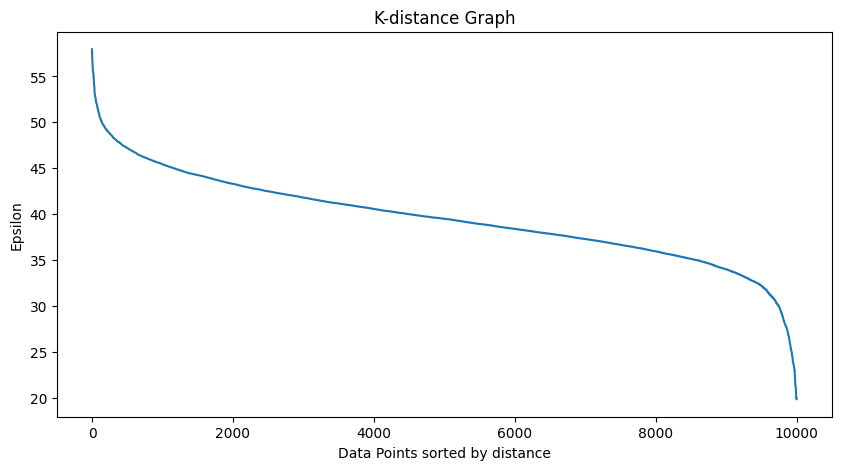

In [62]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming you have a data matrix X
# Compute the nearest neighbors
X = user_book_matrix[:10000]
X.columns = X.columns.astype(str)
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort the distances
distances = sorted(distances[:, 1], reverse=True)


In [81]:
indices

array([[   0, 9255],
       [   1, 2160],
       [   2, 9255],
       ...,
       [9997, 7932],
       [9998, 7279],
       [9999, 9255]], dtype=int64)

In [83]:
%matplotlib inline

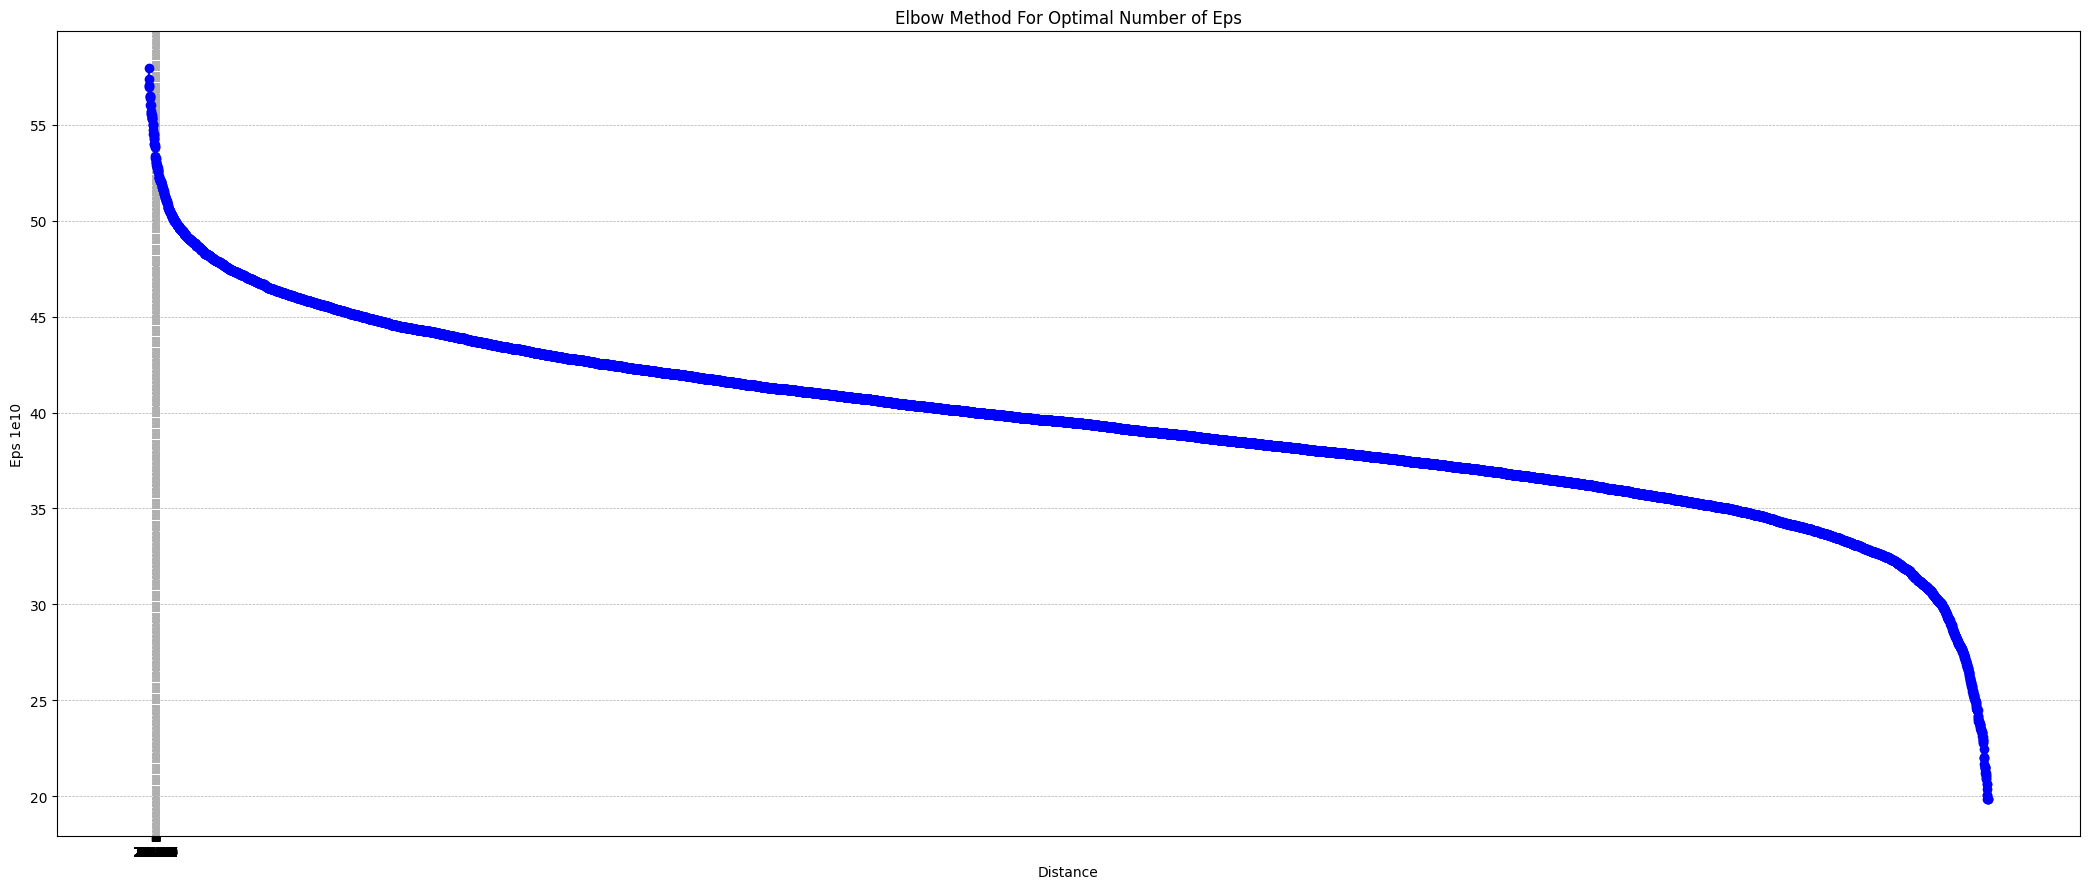

In [88]:
# Побудова графіку
plt.figure(figsize=(21,9))
plt.plot(distances, marker='o', linestyle='--', color='b')
# plt.scatter(7, inertia[6], color='red', s=100, zorder=5)
plt.xlabel('Distance')
plt.ylabel('Eps 1e10')
plt.title('Elbow Method For Optimal Number of Eps')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(distances)  # Set x-axis ticks to be integers for better clarity
plt.tight_layout()  # Adjust layout for better appearance
plt.savefig('my_plot.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [30]:
# Застосування DBSCAN
from sklearn.cluster import OPTICS
db = OPTICS(min_samples=4).fit(scaled_data)
labels = db.labels_


KeyboardInterrupt: 

In [60]:
# Додавання результатів кластеризації до даних
user_book_matrix['cluster'] = clusters

In [61]:
# Виведення результатів
print(f"Total clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Users in noise cluster: {(clusters == -1).sum()}")

Total clusters: 7
Users in noise cluster: 0


In [64]:
recommendations = {}

for user in recommendations:
    books_to_add = to_read[to_read['user_id'] == user]['book_id'].tolist()
    recommendations[user].extend(books_to_add)


## DQN

In [90]:
import random
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [91]:
# Створення матриці користувач-книга
user_book_matrix = sample_train_ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

In [92]:
state_size = len(user_book_matrix.columns)
action_size = len(user_book_matrix.columns) - 1  # виключаючи колонку 'cluster'
batch_size = 64
n_episodes = 100

# Модель DQN
model = Sequential()
model.add(Dense(24, input_dim=state_size, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(action_size, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=0.001))

# Функція для вибору дії на основі кластера користувача
def choose_action(state, user_cluster):
    if np.random.rand() <= 0.1:
        return random.randrange(action_size)
    act_values = model.predict(state)
    
    # Віддаємо перевагу рекомендаціям на основі кластера користувача
    cluster_books = user_book_matrix[user_book_matrix['cluster'] == user_cluster].mean().drop('cluster')
    act_values = act_values * cluster_books.values
    
    return np.argmax(act_values[0])

# Заглушка для функції навчання DQN
def train_dqn():
    # Реалізація навчання DQN тут
    pass

# Примітка: Функція навчання DQN потребує подальшої реалізації на основі конкретного механізму винагороди та даних про взаємодію.

# Agglomerative clustering + Actor-Critic

In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix

## Clustering

In [37]:
sample_size = 0.005
# Split data into training and test sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
sample_train_ratings = train_ratings.sample(frac=sample_size, random_state=42)

In [38]:
sample_train_ratings

,user_id,book_id,rating,cluster
4116960,35652,939,4,3
5464415,5798,5784,4,3
437854,8607,194,1,5
2352113,30013,993,3,3
2202553,16527,6757,4,0
...,...,...,...,...
3552038,41924,786,5,1
5004423,51561,265,5,5
3172517,17546,1343,4,4
3507927,41556,105,4,0


In [28]:
user_book_matrix = train_ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

In [29]:
user_book_matrix

book_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,0.0,5.0,3.0,0.0,2.0,0.0,0.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53421,4.0,5.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53422,4.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
user_cluster_mapping = pd.DataFrame({'user_id': user_book_matrix.index, 'cluster': clusters})

# Merge this mapping with the ratings dataframe
ratings = pd.merge(ratings, user_cluster_mapping, on='user_id', how='left')

In [20]:
# Convert the user-item matrix into a sparse matrix for efficiency
sparse_matrix = csr_matrix(user_book_matrix[:10000].values)

best_silhouette = -1
best_n_clusters = 0
n_c = []

# Iterate over a range of cluster numbers (e.g., from 2 to 15)
for n_clusters in range(2, 16):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = agg_clustering.fit_predict(sparse_matrix.toarray())
    
    silhouette_avg = silhouette_score(sparse_matrix, clusters)
    print(f'Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}')
    
    n_c.append(silhouette_avg)

    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f'Optimal number of clusters: {best_n_clusters} with Silhouette Score: {best_silhouette:.2f}')

Silhouette Score for 2 clusters: 0.05
Silhouette Score for 3 clusters: 0.06
Silhouette Score for 4 clusters: 0.06
Silhouette Score for 5 clusters: 0.06
Silhouette Score for 6 clusters: 0.04
Silhouette Score for 7 clusters: 0.04
Silhouette Score for 8 clusters: 0.04



KeyboardInterrupt



In [15]:
scaled_data = StandardScaler().fit_transform(user_book_matrix)

In [13]:
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=7).fit(scaled_data)
labels = agg_clustering.labels_

In [19]:
print(pd. DataFrame(clusters, columns=['cluster']).to_csv('agglo-clusters.csv'))

None


In [18]:
# Виведення результатів
print(f"Total clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Users in noise cluster: {(labels == -1).sum()}")

Total clusters: 7
Users in noise cluster: 0


## Actor-Critic

In [41]:
ratings['cluster']

0          0
1          5
2          5
3          5
4          5
          ..
5976474    5
5976475    5
5976476    5
5976477    5
5976478    5
Name: cluster, Length: 5976479, dtype: int64

In [51]:
user_book_matrix['cluster'] = clusters
user_book_matrix

book_id,1,2,3,4,5,6,7,8,9,10,...,9992,9993,9994,9995,9996,9997,9998,9999,10000,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,5.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,0.0,5.0,3.0,0.0,2.0,0.0,0.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
53421,4.0,5.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
53422,4.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [52]:
# Actor-Critic Model
state_size = len(user_book_matrix.columns)
action_size = len(user_book_matrix.columns) - 1  # виключаючи колонку 'cluster'


In [53]:
# Actor Model
actor_input = Input(shape=(state_size,))
actor_hidden = Dense(24, activation='relu')(actor_input)
actor_hidden = Dense(24, activation='relu')(actor_hidden)
actor_output = Dense(action_size, activation='softmax')(actor_hidden)
actor_model = Model(inputs=actor_input, outputs=actor_output)


In [54]:
# Critic Model
critic_input = Input(shape=(state_size,))
critic_hidden = Dense(24, activation='relu')(critic_input)
critic_hidden = Dense(24, activation='relu')(critic_hidden)
critic_output = Dense(1, activation='linear')(critic_hidden)
critic_model = Model(inputs=critic_input, outputs=critic_output)

In [55]:
# Compile the models
actor_model.compile(loss='categorical_crossentropy', optimizer='adam')
critic_model.compile(loss='mse', optimizer='adam')

In [ ]:
# Actor-Critic Training

gamma = 0.95
for episode in range(100):
    state = user_book_matrix.sample(1).drop('cluster', axis=1).values
    user_cluster = user_book_matrix.sample(1)['cluster'].values[0]
    cluster_books = user_book_matrix[user_book_matrix['cluster'] == user_cluster].mean().drop('cluster')
    
    for step in range(10):  # Assuming 10 steps per episode
        action_prob = actor_model.predict(state)
        action_prob = action_prob * cluster_books.values
        action = np.random.choice(action_size, p=action_prob[0])
        
        # Reward mechanism based on user interaction
        # Placeholder: Assuming a binary feedback (1 for positive, -1 for negative)
        user_feedback = 1 if np.random.rand() > 0.5 else -1  # This should be replaced with actual user feedback
        reward = user_feedback
        
        # Transition to the next state
        # Placeholder: Assuming the state changes slightly based on user interaction
        next_state = state + 0.1 * user_feedback  # This should be replaced with an actual state transition mechanism
        
        target = reward + gamma * critic_model.predict(next_state)
        advantage = target - critic_model.predict(state)
        
        # Update the actor model
        labels = np.zeros(action_size)
        labels[action] = advantage
        actor_model.fit(state, labels.reshape(1, -1), epochs=1, verbose=0)
        
        # Update the critic model
        critic_model.fit(state, target, epochs=1, verbose=0)
        
        state = next_state
